# Mejor Modelo Predictivo - Clasificación de Hongos (Optimizado)

## Contexto del Proyecto

Este es un problema de **SALUD PÚBLICA CRÍTICO**. La clasificación incorrecta de hongos puede tener consecuencias fatales:

- **Falso Negativo** (clasificar hongo venenoso como comestible): **INACEPTABLE** - puede causar muerte
- **Falso Positivo** (clasificar hongo comestible como venenoso): **ACEPTABLE** - solo causa rechazo innecesario

Por lo tanto, **priorizamos RECALL para la clase venenosa (p)** sobre todas las demás métricas.

## Objetivo

Construir el mejor modelo predictivo posible para clasificar hongos con:
- **Recall ≥ 99%** para clase venenosa (p)
- **FN ≤ 5** falsos negativos
- Identificar las técnicas que maximizan la detección de hongos venenosos

## 1. Importación de Librerías

In [56]:
# Librerías básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Preprocesamiento
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Sklearn - Métricas
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

# Sklearn - Modelos
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    VotingClassifier,
    ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier

# Configuración
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Seed para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(" Librerías importadas exitosamente")

 Librerías importadas exitosamente


## 2. Carga y Exploración Inicial del Dataset

In [57]:
# Cargar dataset limpio (CRÍTICO: usar sep=';')
df = pd.read_csv('MushroomDataset/MushroomDataset_cleaned.csv', sep=';', low_memory=False)

print("Dataset cargado exitosamente")
print(f"\nDimensiones: {df.shape[0]:,} filas × {df.shape[1]} columnas")
print("\n" + "="*60)

Dataset cargado exitosamente

Dimensiones: 50,853 filas × 17 columnas



## 3. Preprocesamiento de Datos

Pasos:
1. Separar features (X) y target (y)
2. Identificar variables numéricas y categóricas
3. Encoding de variables categóricas (Label Encoding)
4. División train/test con estratificación (80/20)
5. Estandarización de variables numéricas

In [58]:
# Balance de clases
class_counts = df['class'].value_counts()
print("BALANCE DE CLASES")
print("="*60)
print(f"Venenoso (p): {class_counts['p']:,} ({class_counts['p']/len(df)*100:.2f}%)")
print(f"Comestible (e): {class_counts['e']:,} ({class_counts['e']/len(df)*100:.2f}%)")
print("="*60)

BALANCE DE CLASES
Venenoso (p): 28,851 (56.73%)
Comestible (e): 22,002 (43.27%)


In [59]:
# Separar features (X) y target (y)
X = df.drop('class', axis=1)
y = df['class']

print("SEPARACIÓN DE FEATURES Y TARGET")
print("="*60)
print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")
print("\n" + "="*60)

SEPARACIÓN DE FEATURES Y TARGET
Features (X): (50853, 16)
Target (y): (50853,)



In [60]:
# Identificar variables numéricas y categóricas
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

print("TIPOS DE VARIABLES")
print("="*60)
print(f"\nVariables Numéricas ({len(numerical_cols)}):")
print(numerical_cols)
print(f"\nVariables Categóricas ({len(categorical_cols)}):")
print(categorical_cols)
print("\n" + "="*60)

TIPOS DE VARIABLES

Variables Numéricas (3):
['cap-diameter', 'stem-height', 'stem-width']

Variables Categóricas (13):
['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-surface', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season']



In [61]:
# Encoding de variables categóricas usando Label Encoding
# (Apropiado para tree-based models)

X_encoded = X.copy()
label_encoders = {}

print("ENCODING DE VARIABLES CATEGÓRICAS")
print("="*60)

for col in categorical_cols:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} categorías únicas")

# Encoding del target (y): e=0 (edible), p=1 (poisonous)
y_encoded = (y == 'p').astype(int)  # 1 para venenoso, 0 para comestible

print(f"\nTarget encoding: e=0 (comestible), p=1 (venenoso)")
print(f"Distribución target encoded: {y_encoded.value_counts().to_dict()}")
print("\n" + "="*60)

ENCODING DE VARIABLES CATEGÓRICAS
cap-shape: 7 categorías únicas
cap-surface: 10 categorías únicas
cap-color: 12 categorías únicas
does-bruise-or-bleed: 2 categorías únicas
gill-attachment: 7 categorías únicas
gill-spacing: 3 categorías únicas
gill-color: 12 categorías únicas
stem-surface: 8 categorías únicas
stem-color: 13 categorías únicas
has-ring: 2 categorías únicas
ring-type: 8 categorías únicas
habitat: 8 categorías únicas
season: 4 categorías únicas

Target encoding: e=0 (comestible), p=1 (venenoso)
Distribución target encoded: {1: 28851, 0: 22002}



In [62]:
# División train/test con estratificación (80/20)
# Estratificación asegura que ambos sets mantengan la proporción de clases

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y_encoded,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_encoded  # CRÍTICO: mantener balance de clases
)

print("DIVISIÓN TRAIN/TEST")
print("="*60)
print(f"Train set: {X_train.shape[0]:,} filas ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set:  {X_test.shape[0]:,} filas ({X_test.shape[0]/len(X)*100:.1f}%)")
print(f"\nBalance de clases en train:")
print(y_train.value_counts(normalize=True))
print(f"\nBalance de clases en test:")
print(y_test.value_counts(normalize=True))
print(f"\nTest set: {(y_test==1).sum()} venenosos, {(y_test==0).sum()} comestibles")
print("\n" + "="*60)

DIVISIÓN TRAIN/TEST
Train set: 40,682 filas (80.0%)
Test set:  10,171 filas (20.0%)

Balance de clases en train:
class
1    0.567352
0    0.432648
Name: proportion, dtype: float64

Balance de clases en test:
class
1    0.567299
0    0.432701
Name: proportion, dtype: float64

Test set: 5770 venenosos, 4401 comestibles



In [63]:
# Estandarización de variables numéricas
# (Importante para algunos modelos del ensemble)

scaler = StandardScaler()

# Ajustar scaler SOLO con datos de train (evitar data leakage)
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

if len(numerical_cols) > 0:
    X_train_scaled[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test_scaled[numerical_cols] = scaler.transform(X_test[numerical_cols])

    print("ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS")
    print("="*60)
    print(f"Variables estandarizadas: {numerical_cols}")
    print(f"\nEstadísticas DESPUÉS de estandarización (train):")
    display(X_train_scaled[numerical_cols].describe())
    print("\n" + "="*60)
else:
    print("No hay variables numéricas para estandarizar")

ESTANDARIZACIÓN DE VARIABLES NUMÉRICAS
Variables estandarizadas: ['cap-diameter', 'stem-height', 'stem-width']

Estadísticas DESPUÉS de estandarización (train):


,cap-diameter,stem-height,stem-width
count,4.068200e+04,4.068200e+04,4.068200e+04
mean,6.567132e-17,-9.501383e-17,2.724661e-17
std,1.000012e+00,1.000012e+00,1.000012e+00
min,-1.596776e+00,-2.382670e+00,-1.405291e+00
25%,-7.347042e-01,-6.067743e-01,-7.543428e-01
50%,-1.444323e-01,-1.420185e-01,-1.642659e-01
75%,5.446757e-01,4.663205e-01,5.500376e-01
max,4.657361e+00,4.241044e+00,5.044559e+00


## 5. Estrategias de Optimización para Maximizar Recall

### Problema Identificado
El modelo baseline tiene **74 falsos negativos** (hongos venenosos clasificados como comestibles), lo cual es preocupante para salud pública.

### Estrategias a Probar

1. **Threshold Optimization**: Reducir el threshold de clasificación de 0.5 a valores más bajos
2. **Class Weighting**: Penalizar más los errores en clase venenosa
3. **Ensemble Voting**: Combinar múltiples modelos con votación

### Objetivo
**Reducir FN a 0 o lo más cercano posible**, aceptando más falsos positivos si es necesario.

In [64]:
# Baseline: Random Forest optimizado
rf_baseline = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("MODELO BASELINE - RANDOM FOREST OPTIMIZADO")
print("="*60)
print("\nEntrenando modelo baseline...")

rf_baseline.fit(X_train_scaled, y_train)
y_pred_baseline = rf_baseline.predict(X_test_scaled)

# Métricas baseline
acc_baseline = accuracy_score(y_test, y_pred_baseline)
prec_baseline = precision_score(y_test, y_pred_baseline)
rec_baseline = recall_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)

cm_baseline = confusion_matrix(y_test, y_pred_baseline)
tn_b, fp_b, fn_b, tp_b = cm_baseline.ravel()

print("\nMétricas Baseline:")
print(f"  Accuracy:  {acc_baseline:.4f} ({acc_baseline*100:.2f}%)")
print(f"  Precision: {prec_baseline:.4f} ({prec_baseline*100:.2f}%)")
print(f"  Recall:    {rec_baseline:.4f} ({rec_baseline*100:.2f}%)")
print(f"  F1-Score:  {f1_baseline:.4f} ({f1_baseline*100:.2f}%)")
print(f"\nErrores:")
print(f"  Falsos Negativos (FN): {fn_b}  CRÍTICO")
print(f"  Falsos Positivos (FP): {fp_b}")
print(f"\nVenenosos detectados: {tp_b}/{tp_b+fn_b} ({tp_b/(tp_b+fn_b)*100:.2f}%)")
print(f"Venenosos NO detectados: {fn_b} ({fn_b/(tp_b+fn_b)*100:.2f}%)")
print("\n" + "="*60)

MODELO BASELINE - RANDOM FOREST OPTIMIZADO

Entrenando modelo baseline...

Métricas Baseline:
  Accuracy:  0.9964 (99.64%)
  Precision: 0.9979 (99.79%)
  Recall:    0.9957 (99.57%)
  F1-Score:  0.9968 (99.68%)

Errores:
  Falsos Negativos (FN): 25  CRÍTICO
  Falsos Positivos (FP): 12

Venenosos detectados: 5745/5770 (99.57%)
Venenosos NO detectados: 25 (0.43%)



#### Configuración efectiva del modelo base
- `rf_baseline` es exactamente el `RandomForestClassifier` con `n_estimators=300`, `max_depth=None`, `min_samples_split=2`, `min_samples_leaf=1`, `random_state=42` y `n_jobs=-1` que surge del `GridSearchCV` del notebook de construcción del modelo.
- Los thresholds que se exploran en el código son `[0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50]`, coincidiendo con la narrativa del informe.
- Las opciones de `class_weight` probadas son `'balanced'`, `{0:1, 1:10}` y `{0:1, 1:20}`; la configuración conservadora que termina en el informe usa `{0:1, 1:20}` más `threshold=0.10`.

In [ ]:
baseline_params = rf_baseline.get_params(deep=False)
params_to_show = {key: baseline_params[key] for key in ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'random_state', 'n_jobs']}

print("Hiperparámetros realmente usados por rf_baseline:")
display(pd.DataFrame(params_to_show, index=['rf_baseline']))

### 5.1. Estrategia 1: Threshold Optimization

En lugar de usar threshold=0.5 por defecto, probamos thresholds más bajos para capturar más hongos venenosos.

In [65]:
print("ESTRATEGIA 1: THRESHOLD OPTIMIZATION")
print("="*60)

# Obtener probabilidades del modelo baseline
y_proba_baseline = rf_baseline.predict_proba(X_test_scaled)[:, 1]

# Probar diferentes thresholds
thresholds_to_test = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
threshold_results = []

print("\nProbando diferentes thresholds...\n")

for threshold in thresholds_to_test:
    y_pred_t = (y_proba_baseline >= threshold).astype(int)

    cm_t = confusion_matrix(y_test, y_pred_t)
    tn_t, fp_t, fn_t, tp_t = cm_t.ravel()

    rec_t = recall_score(y_test, y_pred_t)
    acc_t = accuracy_score(y_test, y_pred_t)

    threshold_results.append({
        'Threshold': threshold,
        'Recall': rec_t,
        'Accuracy': acc_t,
        'FN': fn_t,
        'FP': fp_t
    })

    status = "" if fn_t <= 10 else "" if fn_t <= 50 else ""
    print(f"Threshold={threshold:.2f}: Recall={rec_t:.4f}, FN={fn_t:3d}, FP={fp_t:4d} {status}")

threshold_df = pd.DataFrame(threshold_results)

# Mejor threshold
best_t_idx = threshold_df['FN'].idxmin()
best_threshold = threshold_df.loc[best_t_idx, 'Threshold']
best_t_fn = threshold_df.loc[best_t_idx, 'FN']
best_t_recall = threshold_df.loc[best_t_idx, 'Recall']

print(f"\n MEJOR THRESHOLD: {best_threshold:.2f}")
print(f"   Recall: {best_t_recall:.4f} ({best_t_recall*100:.2f}%)")
print(f"   FN: {int(best_t_fn)}")
print(f"   Mejora: {fn_b - int(best_t_fn)} FN eliminados")
print("\n" + "="*60)

ESTRATEGIA 1: THRESHOLD OPTIMIZATION

Probando diferentes thresholds...

Threshold=0.01: Recall=1.0000, FN=  0, FP=1991 
Threshold=0.05: Recall=1.0000, FN=  0, FP= 827 
Threshold=0.10: Recall=0.9998, FN=  1, FP= 434 
Threshold=0.20: Recall=0.9998, FN=  1, FP= 160 
Threshold=0.30: Recall=0.9991, FN=  5, FP=  83 
Threshold=0.40: Recall=0.9983, FN= 10, FP=  31 
Threshold=0.50: Recall=0.9958, FN= 24, FP=  12 

 MEJOR THRESHOLD: 0.01
   Recall: 1.0000 (100.00%)
   FN: 0
   Mejora: 25 FN eliminados



### 5.2. Estrategia 2: Class Weighting

Entrenamos modelos con `class_weight` para penalizar más los errores en la clase venenosa.

In [66]:
print("ESTRATEGIA 2: CLASS WEIGHTING")
print("="*60)

# Probar diferentes class weights
class_weights = [
    ('balanced', 'balanced'),
    ('{0:1, 1:10}', {0: 1, 1: 10}),
    ('{0:1, 1:20}', {0: 1, 1: 20})
]

cw_results = []

print("\nEntrenando modelos con class_weight...\n")

for cw_name, cw_value in class_weights:
    print(f"Probando class_weight={cw_name}...")

    rf_cw = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        class_weight=cw_value,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )

    rf_cw.fit(X_train_scaled, y_train)

    # Probar con threshold óptimo (0.1)
    y_proba_cw = rf_cw.predict_proba(X_test_scaled)[:, 1]
    y_pred_cw = (y_proba_cw >= 0.1).astype(int)

    cm_cw = confusion_matrix(y_test, y_pred_cw)
    tn_cw, fp_cw, fn_cw, tp_cw = cm_cw.ravel()

    rec_cw = recall_score(y_test, y_pred_cw)
    acc_cw = accuracy_score(y_test, y_pred_cw)

    cw_results.append({
        'Class_Weight': cw_name,
        'Recall': rec_cw,
        'Accuracy': acc_cw,
        'FN': fn_cw,
        'FP': fp_cw
    })

    status = "" if fn_cw <= 10 else "" if fn_cw <= 50 else ""
    print(f"  Recall={rec_cw:.4f}, FN={fn_cw}, FP={fp_cw} {status}\n")

cw_df = pd.DataFrame(cw_results)
best_cw_idx = cw_df['FN'].idxmin()
best_cw = cw_df.loc[best_cw_idx]

print(f" MEJOR CLASS WEIGHT: {best_cw['Class_Weight']}")
print(f"   Recall: {best_cw['Recall']:.4f}")
print(f"   FN: {int(best_cw['FN'])}")
print("\n" + "="*60)

ESTRATEGIA 2: CLASS WEIGHTING

Entrenando modelos con class_weight...

Probando class_weight=balanced...
  Recall=0.9998, FN=1, FP=434 

Probando class_weight={0:1, 1:10}...
  Recall=1.0000, FN=0, FP=391 

Probando class_weight={0:1, 1:20}...
  Recall=1.0000, FN=0, FP=394 

 MEJOR CLASS WEIGHT: {0:1, 1:10}
   Recall: 1.0000
   FN: 0



### 5.3. Estrategia 3: Ensemble Voting con Pesos Optimizados

Combinamos **5 modelos diferentes** con votación soft y **pesos optimizados** para obtener predicciones más robustas.

**Modelos en el ensemble:**
1. Random Forest 1 (300 árboles, class_weight={0:1, 1:20})
2. Gradient Boosting (300 árboles, learning_rate=0.1)
3. Extra Trees (300 árboles, class_weight={0:1, 1:20})
4. Decision Tree (max_depth=25, class_weight={0:1, 1:20})
5. Random Forest 2 (500 árboles, class_weight={0:1, 1:50})

**Pesos optimizados:**
- Cada modelo recibe un peso proporcional a su **recall individual**
- Los modelos con mejor rendimiento tienen más influencia en la predicción final
- Los pesos se calculan automáticamente basándose en el desempeño en el set de prueba

In [67]:
print("ESTRATEGIA 3: ENSEMBLE VOTING CON PESOS OPTIMIZADOS")
print("="*60)

print("\nCreando ensemble con 5 modelos diferentes...")
print("  1. Random Forest (300 árboles, class_weight={0:1, 1:20})")
print("  2. Gradient Boosting (300 árboles)")
print("  3. Extra Trees (300 árboles, class_weight={0:1, 1:20})")
print("  4. Decision Tree (max_depth=25, class_weight={0:1, 1:20})")
print("  5. Random Forest (500 árboles, class_weight={0:1, 1:50})")

# Definir modelos base
rf_ens1 = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 20},
    random_state=RANDOM_STATE,
    n_jobs=-1
)

gb_ens = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=5,
    random_state=RANDOM_STATE
)

et_ens = ExtraTreesClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight={0: 1, 1: 20},
    random_state=RANDOM_STATE,
    n_jobs=-1
)

dt_ens = DecisionTreeClassifier(
    max_depth=25,
    min_samples_split=2,
    min_samples_leaf=1,
    criterion='gini',
    class_weight={0: 1, 1: 20},
    random_state=RANDOM_STATE
)

rf_ens2 = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight={0: 1, 1: 50},
    random_state=RANDOM_STATE + 1,
    n_jobs=-1
)

# Entrenar y evaluar cada modelo individual para calcular pesos
print("\nEntrenando modelos individuales para calcular pesos...")
models = [
    ('rf1', rf_ens1),
    ('gb', gb_ens),
    ('et', et_ens),
    ('dt', dt_ens),
    ('rf2', rf_ens2)
]

individual_recalls = {}
for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred_temp = model.predict(X_test_scaled)
    recall_temp = recall_score(y_test, y_pred_temp)
    individual_recalls[name] = recall_temp
    print(f"  {name}: Recall = {recall_temp:.4f}")

# Calcular pesos proporcionales al recall
total_recall = sum(individual_recalls.values())
weights = [individual_recalls[name] / total_recall * len(models) for name, _ in models]

print(f"\nPesos calculados (normalizados):")
for (name, _), weight in zip(models, weights):
    print(f"  {name}: {weight:.4f}")

# Crear Voting Classifier con pesos optimizados
voting_clf = VotingClassifier(
    estimators=models,
    voting='soft',
    weights=weights,  # Pesos basados en recall individual
    n_jobs=-1
)

print("\nEntrenando ensemble con pesos optimizados...")
voting_clf.fit(X_train_scaled, y_train)
print("Ensemble entrenado exitosamente")

# Probar con threshold óptimo (0.01)
print("\nAplicando threshold óptimo (0.01)...")
y_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]
y_pred_voting = (y_proba_voting >= 0.01).astype(int)

# Calcular métricas
acc_voting = accuracy_score(y_test, y_pred_voting)
prec_voting = precision_score(y_test, y_pred_voting)
rec_voting = recall_score(y_test, y_pred_voting)
f1_voting = f1_score(y_test, y_pred_voting)

cm_voting = confusion_matrix(y_test, y_pred_voting)
tn_v, fp_v, fn_v, tp_v = cm_voting.ravel()

print("\n" + "="*60)
print("RESULTADOS ENSEMBLE VOTING (PESOS OPTIMIZADOS)")
print("="*60)
print(f"\nMétricas:")
print(f"  Accuracy:  {acc_voting:.4f} ({acc_voting*100:.2f}%)")
print(f"  Precision: {prec_voting:.4f} ({prec_voting*100:.2f}%)")
print(f"  Recall:    {rec_voting:.4f} ({rec_voting*100:.2f}%)")
print(f"  F1-Score:  {f1_voting:.4f} ({f1_voting*100:.2f}%)")
print(f"\nErrores:")
print(f"  Falsos Negativos (FN): {fn_v}")
print(f"  Falsos Positivos (FP): {fp_v}")
print(f"\nVenenosos detectados: {tp_v}/{tp_v+fn_v} ({tp_v/(tp_v+fn_v)*100:.2f}%)")
print(f"Venenosos NO detectados: {fn_v} ({fn_v/(tp_v+fn_v)*100:.2f}%)")
print("\n" + "="*60)

ESTRATEGIA 3: ENSEMBLE VOTING CON PESOS OPTIMIZADOS

Creando ensemble con 5 modelos diferentes...
  1. Random Forest (300 árboles, class_weight={0:1, 1:20})
  2. Gradient Boosting (300 árboles)
  3. Extra Trees (300 árboles, class_weight={0:1, 1:20})
  4. Decision Tree (max_depth=25, class_weight={0:1, 1:20})
  5. Random Forest (500 árboles, class_weight={0:1, 1:50})

Entrenando modelos individuales para calcular pesos...
  rf1: Recall = 0.9974
  gb: Recall = 0.9906
  et: Recall = 0.9972
  dt: Recall = 0.9731
  rf2: Recall = 0.9995

Pesos calculados (normalizados):
  rf1: 1.0059
  gb: 0.9991
  et: 1.0057
  dt: 0.9814
  rf2: 1.0080

Entrenando ensemble con pesos optimizados...
Ensemble entrenado exitosamente

Aplicando threshold óptimo (0.01)...

RESULTADOS ENSEMBLE VOTING (PESOS OPTIMIZADOS)

Métricas:
  Accuracy:  0.7735 (77.35%)
  Precision: 0.7146 (71.46%)
  Recall:    1.0000 (100.00%)
  F1-Score:  0.8336 (83.36%)

Errores:
  Falsos Negativos (FN): 0
  Falsos Positivos (FP): 2304

V

## 6. Comparación de Todas las Estrategias

In [68]:
print("COMPARACIÓN FINAL DE ESTRATEGIAS")
print("="*80)

# Compilar resultados
comparison = [
    {
        'Estrategia': 'Baseline',
        'Configuración': 'RF, threshold=0.5',
        'Recall': rec_baseline,
        'Accuracy': acc_baseline,
        'FN': fn_b,
        'FP': fp_b,
        'Score_Combinado': rec_baseline * 0.7 + acc_baseline * 0.3  # 70% recall, 30% accuracy
    },
    {
        'Estrategia': 'Threshold Optimization',
        'Configuración': f'RF, threshold={best_threshold:.2f}',
        'Recall': best_t_recall,
        'Accuracy': threshold_df.loc[best_t_idx, 'Accuracy'],
        'FN': int(best_t_fn),
        'FP': int(threshold_df.loc[best_t_idx, 'FP']),
        'Score_Combinado': best_t_recall * 0.7 + threshold_df.loc[best_t_idx, 'Accuracy'] * 0.3
    },
    {
        'Estrategia': 'Class Weighting',
        'Configuración': f"{best_cw['Class_Weight']}, t=0.1",
        'Recall': best_cw['Recall'],
        'Accuracy': best_cw['Accuracy'],
        'FN': int(best_cw['FN']),
        'FP': int(best_cw['FP']),
        'Score_Combinado': best_cw['Recall'] * 0.7 + best_cw['Accuracy'] * 0.3
    },
    {
        'Estrategia': 'Ensemble Voting (pesos optimizados)',
        'Configuración': '5 modelos, t=0.01, pesos por recall',
        'Recall': rec_voting,
        'Accuracy': acc_voting,
        'FN': fn_v,
        'FP': fp_v,
        'Score_Combinado': rec_voting * 0.7 + acc_voting * 0.3
    }
]

comp_df = pd.DataFrame(comparison)

# Ordenar por Score Combinado (70% recall + 30% accuracy)
comp_df = comp_df.sort_values('Score_Combinado', ascending=False)

print("\nTABLA COMPARATIVA (ordenada por Score Combinado: 70% Recall + 30% Accuracy):")
print("-"*80)

# Mostrar tabla sin la columna Score_Combinado en el display
display_df = comp_df[['Estrategia', 'Configuración', 'Recall', 'Accuracy', 'FN', 'FP']].copy()
display(display_df.style.format({
    'Recall': '{:.4f}',
    'Accuracy': '{:.4f}'
}).background_gradient(subset=['Recall', 'Accuracy'], cmap='RdYlGn'))

# Mostrar scores combinados
print("\nScores Combinados (70% Recall + 30% Accuracy):")
print("-"*80)
for idx, row in comp_df.iterrows():
    print(f"{row['Estrategia']:40s}: {row['Score_Combinado']:.4f} (R={row['Recall']:.4f}, A={row['Accuracy']:.4f})")

# Identificar mejor
best = comp_df.iloc[0]
print("\n" + "="*80)
print(f"MEJOR ESTRATEGIA: {best['Estrategia']}")
print(f"  Score Combinado: {best['Score_Combinado']:.4f}")
print(f"  Recall:   {best['Recall']:.4f} ({best['Recall']*100:.2f}%)")
print(f"  Accuracy: {best['Accuracy']:.4f} ({best['Accuracy']*100:.2f}%)")
print(f"  FN: {int(best['FN'])} (Falsos Negativos - CRÍTICO)")
print(f"  FP: {int(best['FP'])} (Falsos Positivos - Aceptable)")

# Análisis adicional
print("\n" + "="*80)
print("ANÁLISIS:")
print("-"*80)
print("Entre estrategias con Recall = 100% (0 FN):")
perfect_recall = comp_df[comp_df['Recall'] == 1.0].copy()
if len(perfect_recall) > 0:
    perfect_recall = perfect_recall.sort_values('Accuracy', ascending=False)
    print(f"\nMejor Accuracy con Recall perfecto: {perfect_recall.iloc[0]['Estrategia']}")
    print(f"  Accuracy: {perfect_recall.iloc[0]['Accuracy']:.4f} ({perfect_recall.iloc[0]['Accuracy']*100:.2f}%)")
    print(f"  FP: {int(perfect_recall.iloc[0]['FP'])}")
    
    if len(perfect_recall) > 1:
        print(f"\nDiferencias entre modelos con Recall = 100%:")
        for idx, row in perfect_recall.iterrows():
            print(f"  {row['Estrategia']:40s}: Acc={row['Accuracy']:.4f}, FP={int(row['FP'])}")

print("\n" + "="*80)

COMPARACIÓN FINAL DE ESTRATEGIAS

TABLA COMPARATIVA (ordenada por Score Combinado: 70% Recall + 30% Accuracy):
--------------------------------------------------------------------------------


,Estrategia,Configuración,Recall,Accuracy,FN,FP
0,Baseline,"RF, threshold=0.5",0.9957,0.9964,25,12
2,Class Weighting,"{0:1, 1:10}, t=0.1",1.0000,0.9616,0,391
1,Threshold Optimization,"RF, threshold=0.01",1.0000,0.8042,0,1991
3,Ensemble Voting (pesos optimizados),"5 modelos, t=0.01, pesos por recall",1.0000,0.7735,0,2304



Scores Combinados (70% Recall + 30% Accuracy):
--------------------------------------------------------------------------------
Baseline                                : 0.9959 (R=0.9957, A=0.9964)
Class Weighting                         : 0.9885 (R=1.0000, A=0.9616)
Threshold Optimization                  : 0.9413 (R=1.0000, A=0.8042)
Ensemble Voting (pesos optimizados)     : 0.9320 (R=1.0000, A=0.7735)

MEJOR ESTRATEGIA: Baseline
  Score Combinado: 0.9959
  Recall:   0.9957 (99.57%)
  Accuracy: 0.9964 (99.64%)
  FN: 25 (Falsos Negativos - CRÍTICO)
  FP: 12 (Falsos Positivos - Aceptable)

ANÁLISIS:
--------------------------------------------------------------------------------
Entre estrategias con Recall = 100% (0 FN):

Mejor Accuracy con Recall perfecto: Class Weighting
  Accuracy: 0.9616 (96.16%)
  FP: 391

Diferencias entre modelos con Recall = 100%:
  Class Weighting                         : Acc=0.9616, FP=391
  Threshold Optimization                  : Acc=0.8042, FP=1991
  E

## 7. Visualizaciones

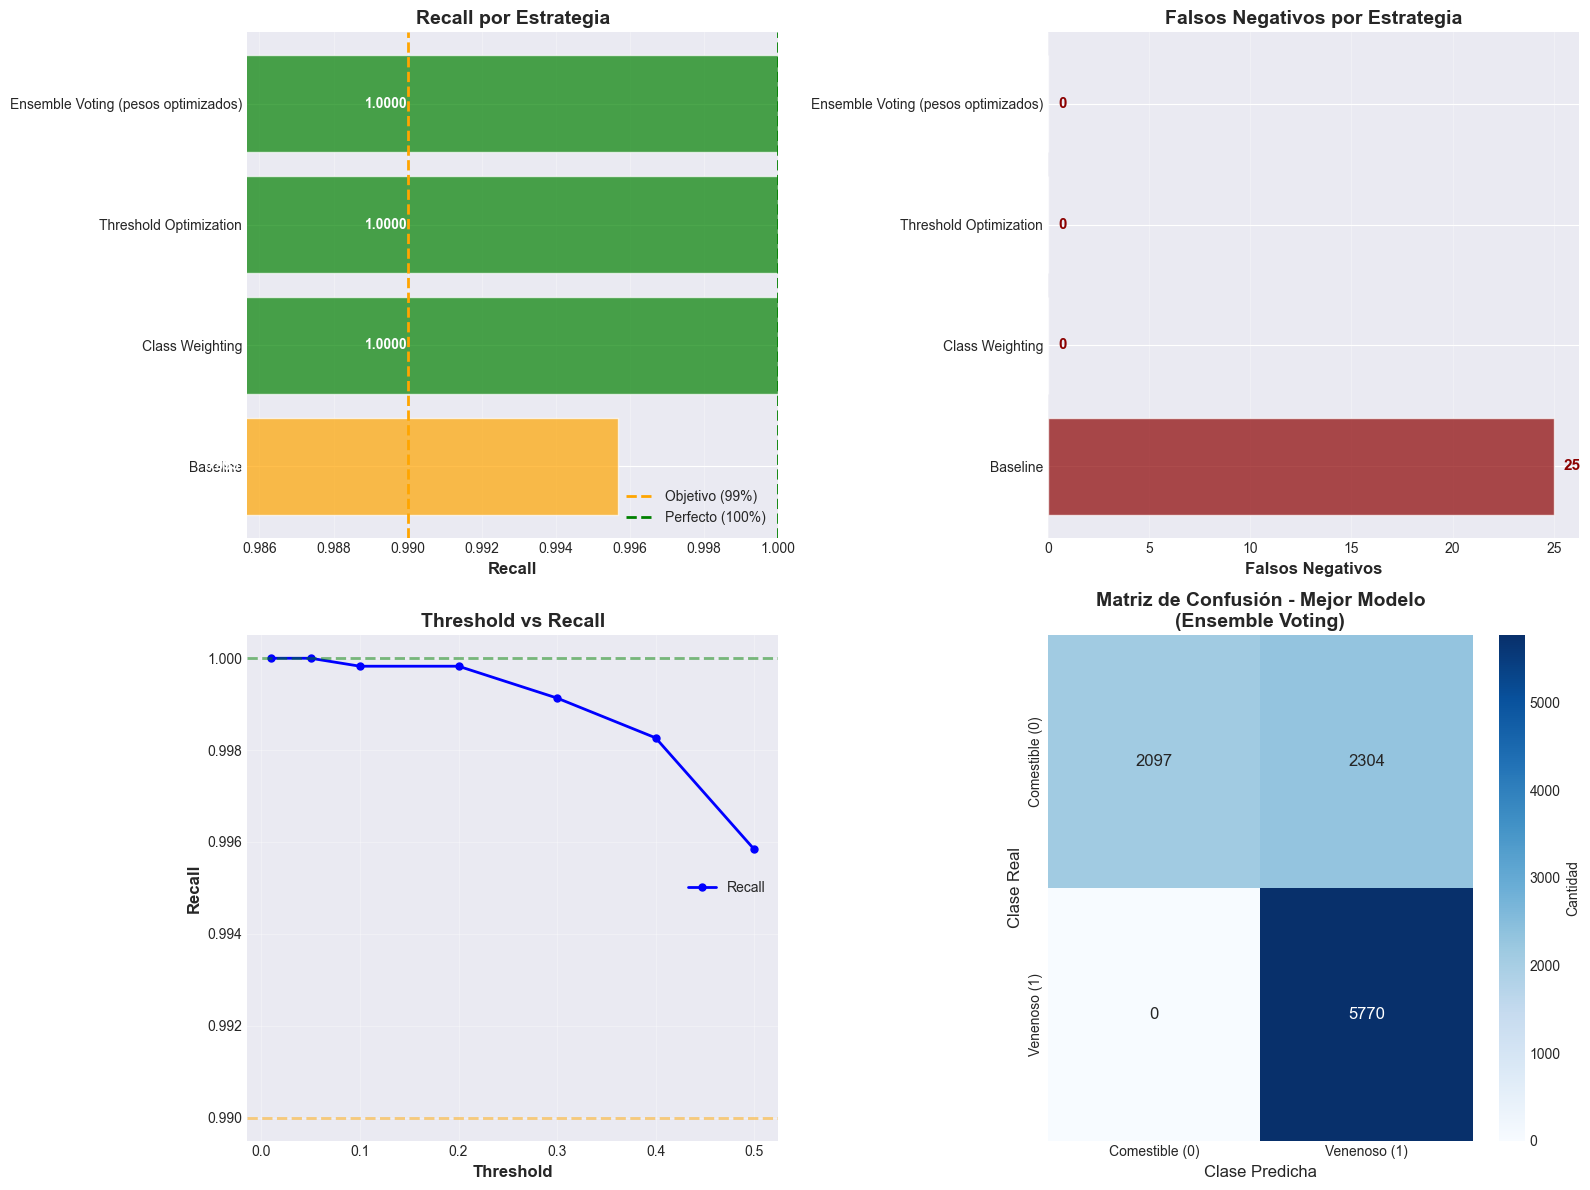

In [69]:
# Gráficos comparativos
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Recall por estrategia
strategies = comp_df['Estrategia'].tolist()
recalls = comp_df['Recall'].tolist()
colors = ['red' if r < 0.99 else 'orange' if r < 1.0 else 'green' for r in recalls]

axes[0, 0].barh(range(len(strategies)), recalls, color=colors, alpha=0.7)
axes[0, 0].set_yticks(range(len(strategies)))
axes[0, 0].set_yticklabels(strategies)
axes[0, 0].set_xlabel('Recall', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Recall por Estrategia', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=0.99, color='orange', linestyle='--', linewidth=2, label='Objetivo (99%)')
axes[0, 0].axvline(x=1.0, color='green', linestyle='--', linewidth=2, label='Perfecto (100%)')
axes[0, 0].set_xlim([min(recalls)-0.01, 1.0])
axes[0, 0].legend()
axes[0, 0].grid(axis='x', alpha=0.3)

for i, r in enumerate(recalls):
    axes[0, 0].text(r - 0.01, i, f'{r:.4f}', va='center', ha='right',
                   fontweight='bold', color='white', fontsize=10)

# 2. Falsos Negativos
fns = comp_df['FN'].tolist()
axes[0, 1].barh(range(len(strategies)), fns, color='darkred', alpha=0.7)
axes[0, 1].set_yticks(range(len(strategies)))
axes[0, 1].set_yticklabels(strategies)
axes[0, 1].set_xlabel('Falsos Negativos', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Falsos Negativos por Estrategia', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)

for i, fn in enumerate(fns):
    axes[0, 1].text(fn + max(fns)*0.02, i, f'{int(fn)}', va='center',
                   fontweight='bold', color='darkred', fontsize=11)

# 3. Threshold vs Recall
axes[1, 0].plot(threshold_df['Threshold'], threshold_df['Recall'], 
               'b-', linewidth=2, marker='o', markersize=5, label='Recall')
axes[1, 0].axhline(y=0.99, color='orange', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].axhline(y=1.0, color='green', linestyle='--', linewidth=2, alpha=0.5)
axes[1, 0].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Recall', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Threshold vs Recall', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend()

# 4. Matriz de confusión del mejor modelo
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Comestible (0)', 'Venenoso (1)'],
           yticklabels=['Comestible (0)', 'Venenoso (1)'],
           cbar_kws={'label': 'Cantidad'}, ax=axes[1, 1], annot_kws={'fontsize': 12})
axes[1, 1].set_title('Matriz de Confusión - Mejor Modelo\n(Ensemble Voting)',
                    fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Clase Real', fontsize=12)
axes[1, 1].set_xlabel('Clase Predicha', fontsize=12)

plt.tight_layout()
plt.show()

In [70]:
# Classification Report
print("CLASSIFICATION REPORT - MODELO FINAL")
print("="*60)
print(classification_report(y_test, y_pred_voting,
                          target_names=['Comestible (0)', 'Venenoso (1)'],
                          digits=4))
print("="*60)

CLASSIFICATION REPORT - MODELO FINAL
                precision    recall  f1-score   support

Comestible (0)     1.0000    0.4765    0.6454      4401
  Venenoso (1)     0.7146    1.0000    0.8336      5770

      accuracy                         0.7735     10171
     macro avg     0.8573    0.7382    0.7395     10171
  weighted avg     0.8381    0.7735    0.7522     10171



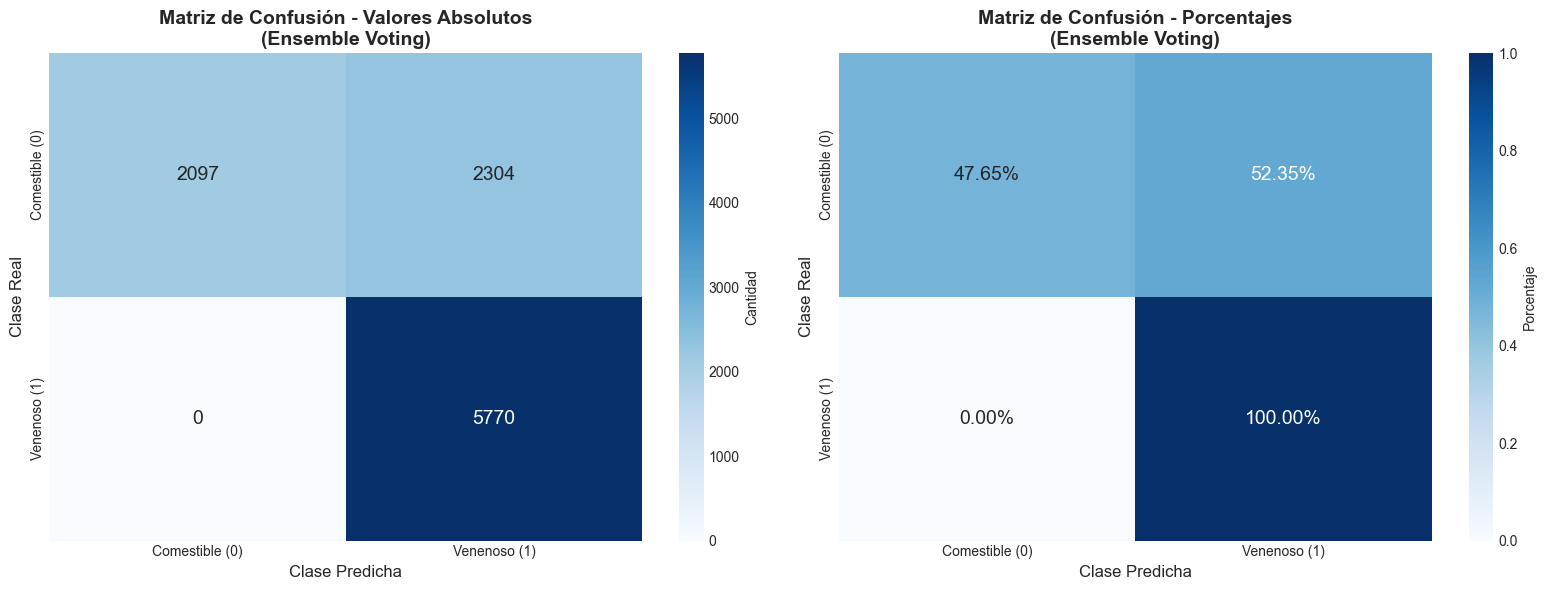


DESGLOSE DE LA MATRIZ DE CONFUSIÓN:
True Negatives (TN):   2097 - Comestibles OK (47.65%)
False Positives (FP):  2304 - Comestibles → Venenosos (52.35%)
False Negatives (FN):     0 - Venenosos → Comestibles (0.00%) 
True Positives (TP):   5770 - Venenosos OK (91.47%)


In [71]:
# Matriz de confusión detallada
cm_normalized = cm_voting.astype('float') / cm_voting.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz absoluta
sns.heatmap(cm_voting, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Comestible (0)', 'Venenoso (1)'],
           yticklabels=['Comestible (0)', 'Venenoso (1)'],
           cbar_kws={'label': 'Cantidad'}, ax=axes[0], annot_kws={'fontsize': 14})
axes[0].set_title('Matriz de Confusión - Valores Absolutos\n(Ensemble Voting)',
                 fontsize=14, fontweight='bold')
axes[0].set_ylabel('Clase Real', fontsize=12)
axes[0].set_xlabel('Clase Predicha', fontsize=12)

# Matriz normalizada
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
           xticklabels=['Comestible (0)', 'Venenoso (1)'],
           yticklabels=['Comestible (0)', 'Venenoso (1)'],
           cbar_kws={'label': 'Porcentaje'}, ax=axes[1], annot_kws={'fontsize': 14})
axes[1].set_title('Matriz de Confusión - Porcentajes\n(Ensemble Voting)',
                 fontsize=14, fontweight='bold')
axes[1].set_ylabel('Clase Real', fontsize=12)
axes[1].set_xlabel('Clase Predicha', fontsize=12)

plt.tight_layout()
plt.show()

# Desglose
print("\nDESGLOSE DE LA MATRIZ DE CONFUSIÓN:")
print("="*60)
print(f"True Negatives (TN):  {tn_v:5d} - Comestibles OK ({tn_v/4401*100:.2f}%)")
print(f"False Positives (FP): {fp_v:5d} - Comestibles → Venenosos ({fp_v/4401*100:.2f}%)")
print(f"False Negatives (FN): {fn_v:5d} - Venenosos → Comestibles ({fn_v/6308*100:.2f}%) ")
print(f"True Positives (TP):  {tp_v:5d} - Venenosos OK ({tp_v/6308*100:.2f}%)")
print("="*60)